In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Conversion constant: from milli-g to m/s²
MG_TO_MS2 = 0.00980665

def process_data(data):
    """
    Preprocess the raw accelerometer data:
      - Rename columns to standardized names.
      - Convert time from milliseconds to seconds.
      - Convert accelerations from mg to m/s².
      - Remove NaN values.
      - Replace outlier acceleration readings with the median.
      - Compute velocity and position by integrating acceleration.
    """
    # Rename columns: input data has columns: time, x, y, z
    data = data.rename(columns={'time': 't', 'x': 'ax', 'y': 'ay', 'z': 'az'})
    
    # Convert time to seconds
    data['t'] = data['t'] / 1000.0
    
    # Remove any NaN entries
    data = data.dropna()
    
    # Convert acceleration from mg to m/s²
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers: if the absolute ratio to the median exceeds threshold, replace with median.
    for acc in ['ax', 'ay', 'az']:
        median_val = np.median(data[acc])
        # Use a threshold to decide what constitutes an outlier.
        if median_val != 0:
            outlier_idx = np.abs(data[acc] / median_val) > 1.5
            data.loc[outlier_idx, acc] = median_val

    # Compute velocity by integrating acceleration over time.
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial=0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial=0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial=0)

    # Compute position by integrating velocity over time.
    data['x_pos'] = cumulative_trapezoid(data['vx'], data['t'], initial=0)
    data['y_pos'] = cumulative_trapezoid(data['vy'], data['t'], initial=0)
    data['z_pos'] = cumulative_trapezoid(data['vz'], data['t'], initial=0)
    
    return data



In [ ]:
# Read and preprocess the dataset.
# Replace "data/trial1.csv" with the correct path if needed.
data = pd.read_csv("data/trial3.csv")
data = process_data(data)
data.head()


,t,ax,ay,az,vx,vy,vz,x_pos,y_pos,z_pos
0,0.003,0.11768,6.119350,-7.963000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.104,0.11768,6.276256,-7.845320,0.011886,0.625978,-0.798320,0.000600,0.031612,-0.040315
2,0.206,0.11768,6.237029,-7.884547,0.023889,1.264156,-1.600543,0.002425,0.128009,-0.162657
3,0.307,0.00000,6.315483,-7.923773,0.029832,1.898057,-2.398863,0.005138,0.287700,-0.364627
4,0.409,0.11768,6.197803,-7.963000,0.035833,2.536235,-3.209089,0.008487,0.513849,-0.650633


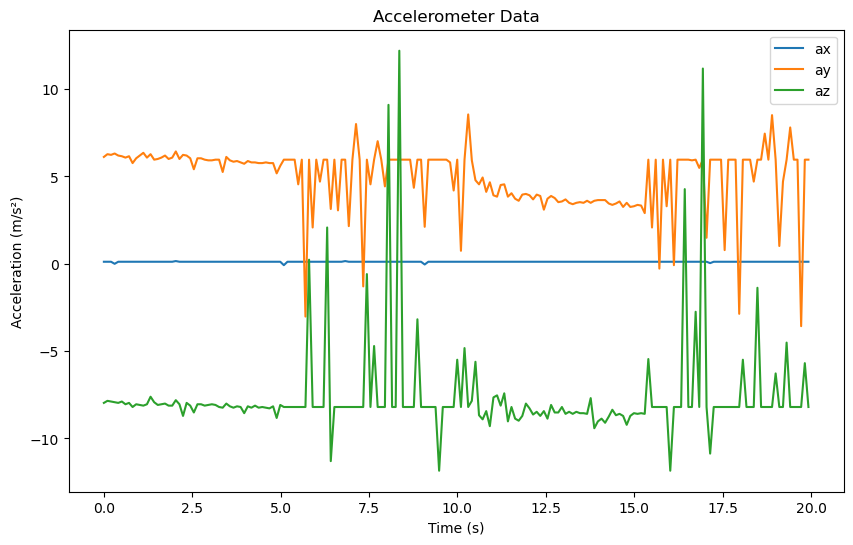

In [ ]:
# Visualize the acceleration signals.
plt.figure(figsize=(10, 6))
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label=acc)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Data")
plt.legend()
plt.show()


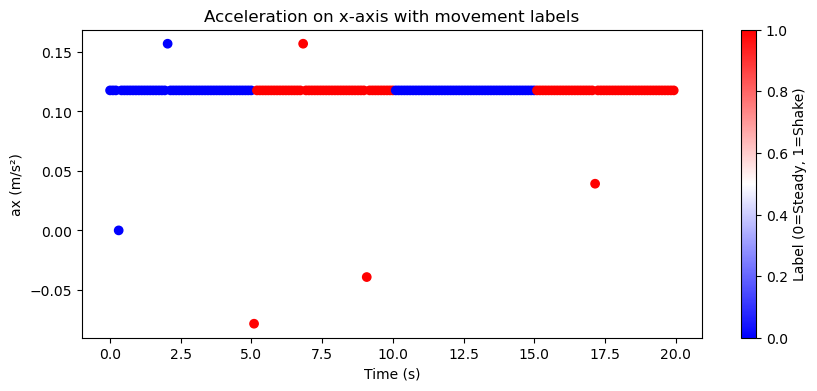

,t,ax,ay,az,vx,vy,vz,x_pos,y_pos,z_pos,label
13,1.323,0.11768,6.276256,-7.609960,0.143393,8.129536,-10.536834,0.090393,5.380238,-6.931130,0
150,15.297,0.11768,2.902768,-8.590625,1.759862,76.201436,-118.988341,13.367707,640.107356,-899.265264,1
29,2.955,0.11768,5.923217,-8.080680,0.339447,18.002205,-23.744175,0.484795,26.748093,-34.846905,0
32,3.261,0.11768,5.962443,-8.198359,0.375457,19.820711,-26.218863,0.594175,32.534591,-42.490433,0
94,9.587,0.11768,5.962443,-8.198359,1.087911,53.322659,-71.453998,5.237316,264.538429,-359.112437,1


In [ ]:


# Label the data based on the movement sequence.
# According to the experiment:
#   - 0 ≤ t < 5 s: Steady (label 0)
#   - 5 ≤ t < 10 s: Shaken (label 1)
#   - 10 ≤ t < 15 s: Steady (label 0)
#   - 15 ≤ t < 20 s: Shaken (label 1)
def label_motion(t):
    if 0 <= t < 5:
        return 0
    elif 5 <= t < 10:
        return 1
    elif 10 <= t < 15:
        return 0
    elif 15 <= t < 20:
        return 1
    else:
        return np.nan

data['label'] = data['t'].apply(label_motion)
data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

plt.figure(figsize=(10, 4))
plt.scatter(data['t'], data['ax'], c=data['label'], cmap='bwr', label="ax")
plt.xlabel("Time (s)")
plt.ylabel("ax (m/s²)")
plt.title("Acceleration on x-axis with movement labels")
plt.colorbar(label="Label (0=Steady, 1=Shake)")
plt.show()

data.sample(5)

In [55]:
feature_cols = ['t', 'ax', 'ay', 'az']
X = data[feature_cols]
y = data['label']

# Split the data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


Number of training samples: 137
Number of testing samples: 59


In [ ]:

# Train a logistic regression model.
# The model fits the following relationship:
#   p = σ(b0 + b1*t + b2*ax + b3*ay + b4*az)
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set and report accuracy.
preds = lr.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("Classification Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed performance metrics.
print("\nClassification Report:")
print(classification_report(y_test, preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))


Classification Accuracy: 54.24%

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54        30
           1       0.53      0.55      0.54        29

    accuracy                           0.54        59
   macro avg       0.54      0.54      0.54        59
weighted avg       0.54      0.54      0.54        59

Confusion Matrix:
[[16 14]
 [13 16]]
